# Trading Strategy

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from backtesting import Backtest, Strategy
from scipy.stats import spearmanr
import argparse
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [21]:
# Load the three datasets
df_vix = pd.read_csv("../2_data/daily_vix.csv", parse_dates=["date"])
df_nvda = pd.read_csv("../2_data/daily_nvda.csv", parse_dates=["Date"]).rename(columns={"Date": "date"})
df_sentiscores = pd.read_csv("../2_data/daily_sentiment_combined.csv", parse_dates=["date"])

# Filter by date range
start_date = "2019-01-01"
end_date = "2022-02-28"
date_range = pd.date_range(start=start_date, end=end_date)
df_all = pd.DataFrame({"date": date_range})

# Add prefix: VIX
df_vix = df_vix[df_vix["date"].between(start_date, end_date)]
df_vix = df_vix.rename(columns=lambda x: f"vix_{x}" if x != "date" else x)

# Add prefix: NVDA
df_nvda.columns = [col.lower() for col in df_nvda.columns]
df_nvda = df_nvda[df_nvda["date"].between(start_date, end_date)]
df_nvda = df_nvda.rename(columns=lambda x: f"nvda_{x}" if x != "date" else x)

# Also filter sentiment data by date range
df_sentiscores = df_sentiscores[df_sentiscores["date"].between(start_date, end_date)]

# Merge datasets sequentially
df_merged = df_all.merge(df_sentiscores[["date", "sentiment_std", "avg_sentiment_score"]], on="date", how="left") \
                  .merge(df_vix, on="date", how="left") \
                  .merge(df_nvda, on="date", how="left")

# Check for missing values
print("Missing values per column:")
print(df_merged.isnull().sum())

# Preview the merged data
print(df_merged.tail())

# Save the result
df_merged.to_csv("factor_data_0518.csv", index=False)

Missing values per column:
date                     0
sentiment_std            0
avg_sentiment_score      0
vix_open               359
vix_high               359
vix_low                359
vix_close              359
nvda_open              359
nvda_high              359
nvda_low               359
nvda_close             359
nvda_volume            359
dtype: int64
           date  sentiment_std  avg_sentiment_score   vix_open   vix_high  \
1150 2022-02-24       0.438374            -0.046854  37.500000  37.790001   
1151 2022-02-25       0.408820            -0.052752  31.680000  32.000000   
1152 2022-02-26       0.481207             0.012048        NaN        NaN   
1153 2022-02-27       0.409719            -0.080460        NaN        NaN   
1154 2022-02-28       0.500721             0.096774  32.439999  33.509998   

        vix_low  vix_close  nvda_open  nvda_high  nvda_low  nvda_close  \
1150  29.450001      30.32    20.9798    23.7605   20.8550     23.7086   
1151  26.930000      27.5

In [22]:
# Load data
df = pd.read_csv('factor_data_0518.csv', parse_dates=['date'])
df = df.sort_values('date').reset_index(drop=True)

# Filter out non-trading days (e.g., days with no stock prices)
df = df.dropna(subset=['nvda_close', 'vix_close'])

# Construct technical and sentiment factors
df['nvda_return'] = df['nvda_close'].pct_change()
df['nvda_ma5'] = df['nvda_close'].rolling(window=5).mean()
df['nvda_volatility'] = df['nvda_return'].rolling(window=5).std()
df['ma_deviation'] = (df['nvda_close'] - df['nvda_ma5']) / df['nvda_ma5']

df['vix_change'] = df['vix_close'].pct_change()
df['vix_range'] = (df['vix_high'] - df['vix_low']) / df['vix_close']

df['volume_change'] = df['nvda_volume'].pct_change()
df['volume_zscore'] = (df['nvda_volume'] - df['nvda_volume'].rolling(10).mean()) / df['nvda_volume'].rolling(10).std()

# Calculate future return over next 5 trading days
df['future_return'] = df['nvda_close'].pct_change().shift(-5)

# Construct sentiment-related features
df['sentiment_diff'] = df['avg_sentiment_score'].diff()
df['sentiment_ma3'] = df['avg_sentiment_score'].rolling(3).mean()
df['sentiment_ema'] = df['avg_sentiment_score'].ewm(span=5).mean()
df['sentiment_zscore'] = (df['avg_sentiment_score'] - df['avg_sentiment_score'].rolling(10).mean()) / df['avg_sentiment_score'].rolling(10).std()

# Nonlinear terms
df['ma_deviation_sq'] = df['ma_deviation'] ** 2
df['vix_change_sq'] = df['vix_change'] ** 2

# Interaction terms
df['interaction_1'] = df['ma_deviation'] * df['vix_change']
df['interaction_2'] = df['sentiment_zscore'] * df['ma_deviation']
df['interaction_3'] = df['sentiment_diff'] * df['vix_change']

# List of raw factor variables
raw_factors = [
    # Technical indicators
    'ma_deviation', 'nvda_volatility', 'vix_change', 'vix_range',
    'volume_change', 'volume_zscore',
    
    # Sentiment indicators
    'avg_sentiment_score', 'sentiment_std', 'sentiment_diff',
    'sentiment_ma3', 'sentiment_ema', 'sentiment_zscore',
    
    # Nonlinear terms
    'ma_deviation_sq', 'vix_change_sq',
    
    # Interaction terms
    'interaction_1', 'interaction_2', 'interaction_3'
]

# Drop rows with missing values in selected factors and target variable
df = df.dropna(subset=raw_factors + ['future_return']).copy()

# Standardize the factors
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[[f + '_z' for f in raw_factors]] = scaler.fit_transform(df[raw_factors])

# Construct composite factor indices
df['index_A'] = df[['ma_deviation_z', 'nvda_volatility_z', 'vix_change_z']].mean(axis=1)
df['index_B'] = df[['ma_deviation_z', 'nvda_volatility_z', 'vix_change_z',
                    'avg_sentiment_score_z', 'sentiment_std_z', 'vix_range_z',
                    'volume_change_z', 'volume_zscore_z']].mean(axis=1)

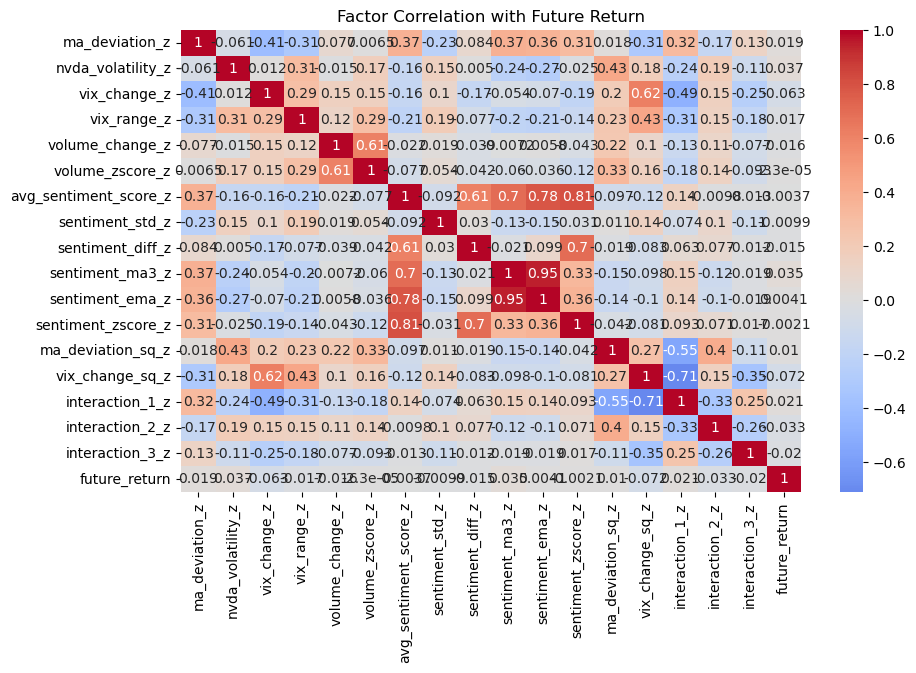

📌 XGBoost Feature Importance Ranking:
                feature  importance
10        sentiment_ema    0.075153
5         volume_zscore    0.073752
3             vix_range    0.072028
15        interaction_2    0.069498
14        interaction_1    0.066967
1       nvda_volatility    0.063367
13        vix_change_sq    0.060038
7         sentiment_std    0.059110
8        sentiment_diff    0.058941
12      ma_deviation_sq    0.055938
2            vix_change    0.053796
11     sentiment_zscore    0.052069
16        interaction_3    0.048791
6   avg_sentiment_score    0.048694
9         sentiment_ma3    0.048343
4         volume_change    0.047249
0          ma_deviation    0.046266


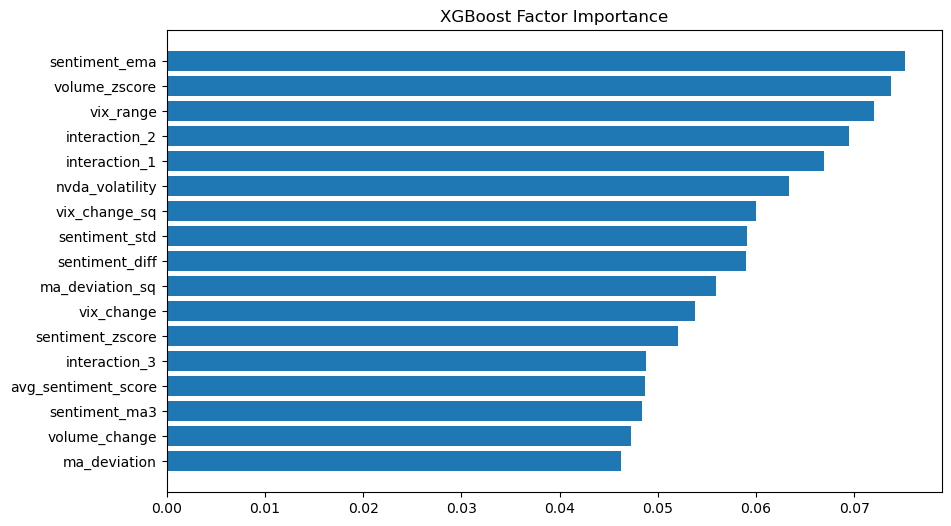

In [23]:
# Visualization: Correlation Between Factors and Future Return
cor_matrix = df[[f + '_z' for f in raw_factors] + ['future_return']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Factor Correlation with Future Return")
plt.show()

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LassoCV

X = df[raw_factors].copy()
y = df['future_return']

# Handle missing values: drop rows with NaNs
X = X.dropna()
y = y.loc[X.index]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

import xgboost as xgb
import matplotlib.pyplot as plt

# Train XGBoost regressor
model = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
model.fit(X_scaled, y)

# Extract feature importances
importances = model.feature_importances_
importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

print("📌 XGBoost Feature Importance Ranking:")
print(importance_df)

# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.gca().invert_yaxis()
plt.title("XGBoost Factor Importance")
plt.show()

# Select top factors based on importance threshold
xgb_selected = importance_df.query('importance > 0.01')['feature'].tolist()

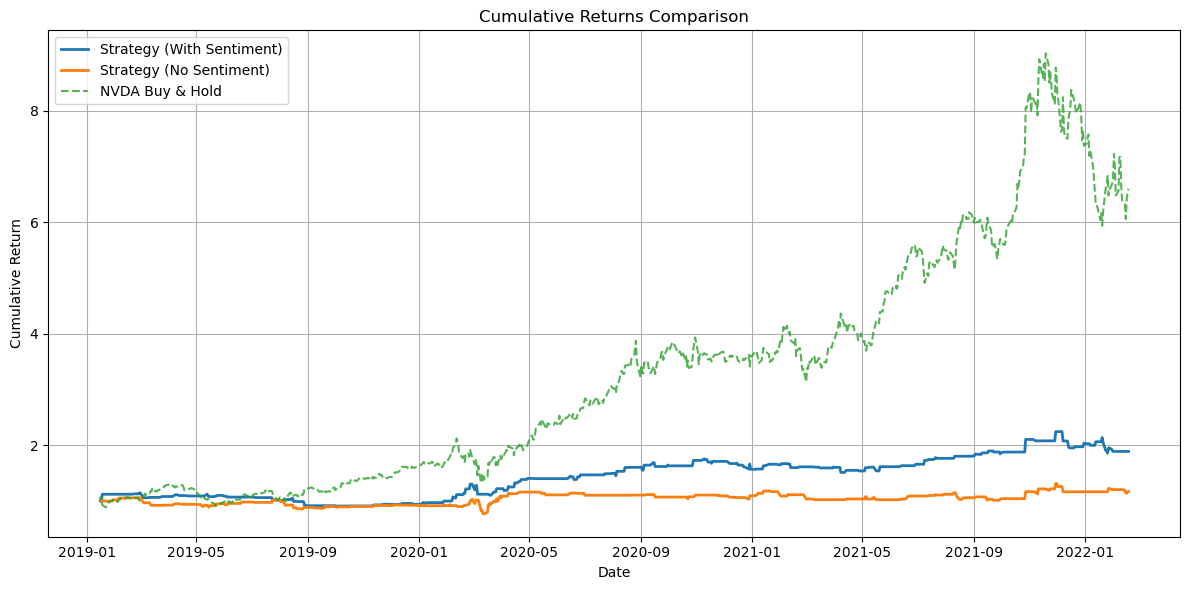

==== Performance Summary ====
With Sentiment       | Annual Return: 23.61%, Volatility: 24.89%, Sharpe: 0.95
Without Sentiment    | Annual Return: 8.75%, Volatility: 26.96%, Sharpe: 0.32
Benchmark (NVDA)     | Annual Return: 72.92%, Volatility: 49.05%, Sharpe: 1.49


(0.7291758977187064, 0.4905032983410959, 1.4865871446426802)

In [24]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# === 1. Define Feature Sets ===
# Full feature set including sentiment
features_all = [
    'nvda_volatility', 'vix_change', 'sentiment_ma3', 'interaction_3',
    'vix_change_sq', 'sentiment_std', 'sentiment_ema', 'ma_deviation',
    'avg_sentiment_score', 'volume_change', 'sentiment_diff'
]

# Subset excluding sentiment-related features
sentiment_features = ['sentiment_ma3', 'interaction_3', 'sentiment_std',
                      'sentiment_ema', 'avg_sentiment_score', 'sentiment_diff']
features_no_sent = [f for f in features_all if f not in sentiment_features]

# === 2. Standardize and Lag Features to Prevent Lookahead Bias ===
df_lagged_all = df[features_all].shift(1).copy()
df_lagged_no_sent = df[features_no_sent].shift(1).copy()

scaler_all = StandardScaler()
scaler_no_sent = StandardScaler()

df_scaled_all = pd.DataFrame(scaler_all.fit_transform(df_lagged_all), columns=features_all, index=df.index)
df_scaled_no_sent = pd.DataFrame(scaler_no_sent.fit_transform(df_lagged_no_sent), columns=features_no_sent, index=df.index)

# === 3. Compute Composite Signals (Weighted Sum by XGBoost Importance) ===
weights_all = importance_df.set_index('feature').loc[features_all]['importance'].values
weights_all /= weights_all.sum()

weights_no_sent = importance_df.set_index('feature').loc[features_no_sent]['importance'].values
weights_no_sent /= weights_no_sent.sum()

df['signal_all'] = df_scaled_all.mul(weights_all, axis=1).sum(axis=1)
df['signal_no_sent'] = df_scaled_no_sent.mul(weights_no_sent, axis=1).sum(axis=1)

# === 4. Convert Signal into Position (Long / Short) ===
def signal_to_position(signal_series):
    upper = signal_series.quantile(0.90)
    lower = signal_series.quantile(0.10)
    position = np.where(signal_series > upper, 1,
                        np.where(signal_series < lower, -1, 0))
    return position

df['position_all'] = signal_to_position(df['signal_all'])
df['position_no_sent'] = signal_to_position(df['signal_no_sent'])

# === 5. Compute Strategy Returns and Cumulative Performance ===
df['strategy_ret_all'] = df['position_all'].shift(1) * df['future_return']
df['strategy_ret_no_sent'] = df['position_no_sent'].shift(1) * df['future_return']

df['cumulative_all'] = (1 + df['strategy_ret_all']).cumprod()
df['cumulative_no_sent'] = (1 + df['strategy_ret_no_sent']).cumprod()
df['cumulative_nvda'] = (1 + df['future_return']).cumprod()

# === 6. Plot Cumulative Return Comparison ===
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['cumulative_all'], label='Strategy (With Sentiment)', linewidth=2)
plt.plot(df['date'], df['cumulative_no_sent'], label='Strategy (No Sentiment)', linewidth=2)
plt.plot(df['date'], df['cumulative_nvda'], label='NVDA Buy & Hold', linestyle='--', alpha=0.8)
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 7. Performance Evaluation ===
def evaluate_performance(returns, name="Strategy"):
    ann_return = returns.mean() * 252
    ann_vol = returns.std() * np.sqrt(252)
    sharpe = ann_return / ann_vol if ann_vol != 0 else np.nan
    print(f"{name:<20} | Annual Return: {ann_return:.2%}, Volatility: {ann_vol:.2%}, Sharpe: {sharpe:.2f}")
    return ann_return, ann_vol, sharpe

print("==== Performance Summary ====")
evaluate_performance(df['strategy_ret_all'].dropna(), "With Sentiment")
evaluate_performance(df['strategy_ret_no_sent'].dropna(), "Without Sentiment")
evaluate_performance(df['future_return'].dropna(), "Benchmark (NVDA)")

- The strategy performance evaluation shows that the strategy with sentiment factor (With Sentiment) significantly outperforms the strategy without sentiment factor (Without Sentiment) in terms of annualised return (23.61%) and Sharpe ratio (0.95), while the latter has an annualised return of only 8.75% and a Sharpe ratio of 0.32. This suggests that the introduction of the sentiment factor is effective in enhancing the profitability and risk-adjusted returns of the strategy. This indicates that the introduction of the sentiment factor effectively improves the profitability and risk-adjusted returns of the strategy.

- 

